# The task of machine learning model optimization  
# "Cells detection from microscope image"
## 1. Problem formulation
### 1.1 Problem description
The task of diagnosing cancer diseases is solved at the cellular level. This research will divide the diagnostic task into 3 steps:
1. tissue sample type classification
2. сells detection from microscope image
3. classification of identified cells and areas

Here is simple illustration:
![The information flow for cancer diagnostic](Information_flow.jpg)

This document is about step №2, in which we research how to isolate all cell instances from the microscope image like this:
![Microscope image example](GE-PTCх200.jpg)

This task has the following difficulties:
- cells of different tissues have completely different shapes and sizes
- image quality can vary greatly
- cellular material can already be treated with dyeing reagents

The combination of these reasons in practical segmentation problems leads to the fact that this problem should be solved using machine learning.
### 1.2. Business problem setting
This research project addresses the challenge of fine-tuning a model for high-quality cell segmentation (instance segmentation) in a microscope image. The resulting segmentation capability is used in further image processing for the purpose of diagnosing diseases at the cell level.
### 1.3. Model accuracy requirements
... section is under analysis
## 2.Preparing the training dataset
### 2.1. Description of the format and composition of the source data
We will use dataset LIVEcell (https://sartorius-research.github.io/LIVECell/), that contains 3000+ microscope images and annotaions for cell's boxes in COCO json format (https://cocodataset.org/#format-data).
Let's start by preparing an adapted class **'livecell'** for working with downloaded images.

In [1]:
#!pip install torchvision==0.15.2
#import torchvision.datasets as dsets

#Modules import
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import os
from skimage import io
import pandas as pd
import json
from PIL import Image
import torchvision
#from torchvision.models.detection import FasterRCNN
#from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
#!pip install icecream
from icecream import ic
import matplotlib.patches as mpatches
import plotly.express as px
import shutil

# Support function to separate 1 COCO-json file into 2 csv    
def convert_coco_json_to_csv(filename):
    s = json.load(open(filename, 'r'))
    out_file_ann = filename[:-5] + '.csv'
    out_ann = open(out_file_ann, 'w')
    out_ann.write('id,x1,y1,x2,y2,label\n')

    out_file_im = filename[:-5] + '_images.csv'
    out_im = open(out_file_im, 'w')
    out_im.write('id,file_name,width,height\n')

    all_ids = []
    for im in s['images']:
        all_ids.append(im['id'])
        out_im.write('{},{},{},{}\n'.format(im['id'], im['file_name'], im['width'], im['height']))
    out_im.close()
    
    all_ids_ann = []
    for ann in s['annotations']:
        image_id = ann['image_id']
        all_ids_ann.append(image_id)
        x1 = ann['bbox'][0]
        x2 = ann['bbox'][0] + ann['bbox'][2]
        y1 = ann['bbox'][1]
        y2 = ann['bbox'][1] + ann['bbox'][3]
        label = ann['category_id']
        out_ann.write('{},{},{},{},{},{}\n'.format(image_id, x1, y1, x2, y2, label))

    all_ids = set(all_ids)
    all_ids_ann = set(all_ids_ann)
    no_annotations = list(all_ids - all_ids_ann)
    # Output images without any annotations
    for image_id in no_annotations:
        out_ann.write('{},{},{},{},{},{}\n'.format(image_id, -1, -1, -1, -1, -1))
    out_ann.close()

    # Sort files by image id
    s1 = pd.read_csv(out_file_ann)
    s1.sort_values('id', inplace=True)
    s1.to_csv(out_file_ann, index=False)
    #======
    s1 = pd.read_csv(out_file_im)
    s1.sort_values('id', inplace=True)
    s1.to_csv(out_file_im, index=False)

### Service utils for tuning Faster R-CNN model

# This class keeps track of the training and validation loss values and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"For epoch: {epoch+1} best validation loss: {self.best_valid_loss}")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'C:\\temp\\datasets\\mediag\\models\\best_model.pth')


def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'C:\\temp\\datasets\\mediag\\models\\last_model.pth')
    
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

def image_size(file_name):
    """
    Return width and height of the image in file 
    """
    img = Image.open(file_name)
    img_size = img.size
    img.close
    return [img_size[0], img_size[1]]


In [2]:
#Define dataset from loaded livecell with annotation in COCO-format
class livecell(Dataset):
    
    # Constructor
    def __init__(self, root_dir="C:\\temp\\datasets\\mediag\\", \
                 dataset_type=1, transform=T.ToTensor(),\
                 subset="", width=704, height=520, sample_count=-1):
        """
        Args:
            root_dir: path to the datasets directory
            dataset_type: 1 - train dataset
                          2 - test dataset
                          3 - validation dataset
            transform: transformation method for initial images
            width, height: standard size for tensor in getter
            sample_count: number of elements in random sample, -1 use all set
            subset: prefix for cell's type selection - not realized yet
        """
        # Detect file names by dataset type
        if dataset_type==1:
            self.images_path  = os.path.join(root_dir,"images\livecell_train_val_images")
            csv_ann_filename  = os.path.join(root_dir, "livecell_coco_train.csv")
            csv_im_filename   = os.path.join(root_dir, "livecell_coco_train_images.csv")
        elif dataset_type==2:
            self.images_path  = os.path.join(root_dir,"images\livecell_test_images")
            csv_ann_filename  = os.path.join(root_dir, "livecell_coco_test.csv")
            csv_im_filename   = os.path.join(root_dir, "livecell_coco_test_images.csv")
        else:
            self.images_path  = os.path.join(root_dir,"images\livecell_train_val_images")
            csv_ann_filename  = os.path.join(root_dir, "livecell_coco_val.csv")
            csv_im_filename   = os.path.join(root_dir, "livecell_coco_val_images.csv")
            
        # Prepare csv files from COCO json, if it is nessesary
        json_filename = csv_ann_filename[:-4] + '.json'
        if not (os.path.exists(csv_ann_filename) and os.path.exists(csv_im_filename)):
            convert_coco_json_to_csv(json_filename)
        # Load csv files to dataframe in dataset
        self.ann = pd.read_csv(csv_ann_filename)
        self.im  = pd.read_csv(csv_im_filename)
        
        # Short to sample if sample_count is enable
        if sample_count!=-1:
            sample_ix = np.random.choice(self.im.index, size=sample_count, replace=False)
            self.im = self.im.loc[sample_ix]
            # Remove all extra annotations
            id_list = self.im.id.values.tolist()
            self.ann = self.ann.loc[self.ann.id.isin(id_list)].reset_index(drop=True)
            # reset indexes
            self.im = self.im.reset_index(drop=True)
        
        # Separate cell type
        self.im["cell_type"]=self.im["file_name"].str.split("_", n=1, expand=True)[0]
        
        # Create structure for RoI results
        cols = {
            "im_id":[0],   # image index, int
            "model":[""],   # name of detection model
            "try_num":[0], # try number
            "x":[0],   # RoI coordinates
            "y":[0],   # RoI coordinates
            "dx":[0],  # RoI coordinates
            "dy":[0],  # RoI coordinates
            "score":[0.0],   # RoI score
        }
        self.RoI = pd.DataFrame(cols, index=[-1])
        # Initialize other properties
        self.len = self.im.shape[0]
        self.transform = transform
        self.height = height
        self.width  = width
        
    # Getter
    def __getitem__(self, index):
        # load image and return it as tensor
        fn = os.path.join(self.images_path, self.im.file_name[index])
        if os.path.exists(fn):
            image_ins = Image.open(fn).convert('RGB') #convert image to RGB channel
            image_tensor = self.transform(image_ins)
        else:
            image_tensor = torch.Tensor([0.0])
            
        # Prepare target dict for torchvision model
        boxes = self.ann[["x1", "y1", "x2", "y2"]] \
                         [self.ann.id==self.im.id[index]].values.tolist()
        len_boxes = len(boxes)
        # Handle empty bounding boxes
        if len_boxes == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.ones((len_boxes,), dtype=torch.int64)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len_boxes,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] =  image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        return image_tensor, target
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Show image with annotations
    def show_data(self, index, width=None, height=None, show_annotation=True,\
                  RoI_model=None, RoI_try_num=None):
        """
        Args:
            index: index of the image
            width, height: displaing size, we take default values from dataset
            show_annotaion: True - add annotation boxes
            RoI_model, RoI_try_num - optional, add detected RoI with saved model and try_num
        """
        if width==None or height==None:
            width = self.im.width[index]
            height = self.im.height[index]
        
        fig, ax = plt.subplots()
        ax.imshow(self[index][0].permute(1, 2, 0).detach().numpy())
        ax.set_title('file = '+ str(self.im.file_name[index]))
        
        if show_annotation:
            # Select all annotation boxes for this image
            boxes_df = self.ann[self.ann.id==self.im.id[index]]
            if boxes_df.shape[0] > 0:
                x_scale = width  / self.im.width[index]
                y_scale = height / self.im.height[index]
                ann_boxes =  [Rectangle((row[0]*x_scale, row[1]*y_scale),\
                                       (row[2]-row[0])*x_scale, (row[3]-row[1])*y_scale) \
                             for row in boxes_df[["x1", "y1", "x2", "y2"]].to_numpy()]

                # Create patch collection
                pc = PatchCollection(ann_boxes, facecolor="none", edgecolor="blue", alpha=0.5)
                # Add collection to axes
                ax.add_collection(pc)
                blue_patch = mpatches.Patch(color='blue', label='Annotations from a trainer')
                red_patch = mpatches.Patch(color='red', label="Detected RoI's")
                ax.legend(handles=[blue_patch, red_patch], fontsize="small")
                
        # Model and try_num for RoI is selected to add RoI boxes
        if type(RoI_model)==str and type(RoI_try_num)==int:
            boxes_df = self.RoI[(self.RoI.im_id==self.im.iloc[index, 0]) \
                               &(self.RoI.model==RoI_model) \
                               &(self.RoI.try_num==RoI_try_num)]
            if boxes_df.shape[0] > 0:
                x_scale = width  / self.im.width[index]
                y_scale = height / self.im.height[index]
                RoI_boxes =  [Rectangle((row[0]*x_scale, row[1]*y_scale),\
                                       (row[2]-row[0])*x_scale, (row[3]-row[1])*y_scale) \
                              for row in boxes_df[["x", "y", "dx", "dy"]].to_numpy()]

                # Create patch collection
                pc = PatchCollection(RoI_boxes, facecolor="none", edgecolor="red", alpha=0.5)
                # Add collection to axes
                ax.add_collection(pc)
            
            
    # Save RoI from model detection
    def save_RoI(self, im_id, boxes, model="FasterT", try_num=0):
        """
        Args:
            im_id: image index
            model: name of the detection model
            boxes: list of RoI in format of Faster R-CNN
            try_num: try number (0 - default)
        """
        
        # Prepare buffer dataframe
        buffer_df=pd.DataFrame(
            [b.type(torch.LongTensor).detach().numpy() for b in boxes["boxes"]],
            columns=["x", "y", "dx", "dy"])
        buffer_df["im_id"] = im_id
        buffer_df["model"] = model
        buffer_df["try_num"] = try_num
        buffer_df["score"] = boxes["scores"].detach().numpy()
        
        # Remove previous version from RoI dataframe
        self.RoI.drop(self.RoI[(self.RoI.im_id==im_id) \
                              & (self.RoI.model==model) \
                              & (self.RoI.try_num==try_num)].index, inplace=True)
        
        # Add buffer to target dataframe
        self.RoI = pd.concat([buffer_df, self.RoI])
        
    # Add images to dataset from directory
    def add_images(self, directory="C:\\temp\\datasets\\mediag\\images\\expert_images\\"):
        """
        Args:
            directory: the directory with images to add in this dataset
        """
        
        # Select all images from directory to list
        prep_files = [f for f in os.listdir(directory) \
                                      if os.path.isfile(os.path.join(directory, f)) \
                                     and (f[-4:]==".jpg" or f[-5:]==".jpeg") \
                                     and os.stat(os.path.join(directory, f)).st_size>1000]
        # Copy file into dataset folder
        for f in prep_files:
            shutil.copy(os.path.join(directory, f), os.path.join(self.images_path, f))
        # fill parameters for new images
        prep_im = pd.DataFrame(columns = self.im.columns)
        prep_im["file_name"] = prep_files
        prep_im["cell_type"] = prep_im["file_name"].str.split("_", n=1, expand=True)[0]
        full_file_name = [os.path.join(self.images_path, f_n)
                          for f_n in prep_im["file_name"]]
        prep_im_size = pd.DataFrame([image_size(f_f_n) for f_f_n in full_file_name])
        prep_im["width"]  = prep_im_size[0]
        prep_im["height"] = prep_im_size[1]
        max_id = self.im.id.max()
        prep_im["id"] = max_id + prep_im.index + 1
        
        ## drop dublicates from dataset (detected by file_name)
        dubl_files = self.im[self.im["file_name"].isin(prep_files)].index
        self.im.drop(dubl_files, axis=0, inplace=True)
        
        self.im = pd.concat([prep_im, self.im])
        self.im.reset_index(drop=True, inplace=True)
        
        # import expert annotations (TBD)
        
        # update dataset parameters
        self.len = self.im.shape[0]

In [3]:
train_set = livecell(dataset_type=1)

## 2.2 Cell type distribution and statistics for annotaions
Let's see images distribution by cell type and how many cells each type has on the images.

In [4]:
# Create train dataset and count images by cell's type
train_set = livecell(dataset_type=1)
train_set.im["count"] = 1
images_total = train_set.im.count()[0]

fig = px.pie(train_set.im, values="count", names="cell_type", title=f"Distribution of {images_total} images by cell type")
fig.show()

We see that the distribution of images by cell type is uniform. In this way, we will be able to obtain an even representation of all cell types in a random sample from the total set of images.
Lets see how many cell's annotations is on each cell type.

In [5]:
# Count annotaions number for every image
ann_count = train_set.ann[["id", "label"]].groupby("id", as_index=False).count()
ann_count["cell_type"] = train_set.im["cell_type"][train_set.im["id"]==ann_count.id]

In [6]:
fig = px.box(ann_count, x="cell_type", y="label", 
             labels={"label": "Cells count on 1 image", "cell_type": "Cell type"},
             title="Distribution cells number by cell type")
fig.show()

We see a huge variation in the number of cells in each image. Let's look at the champion.

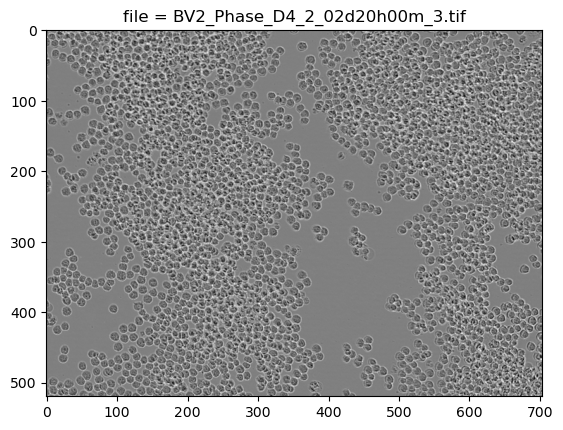

In [7]:
max_id = ann_count.iloc[ann_count["label"].idxmax()]["id"]
train_set.show_data(train_set.im.index[train_set.im.id==max_id][0], show_annotation=False) 

Do you see 3000+ cells here? Neither am I, but they are stated in this photo:

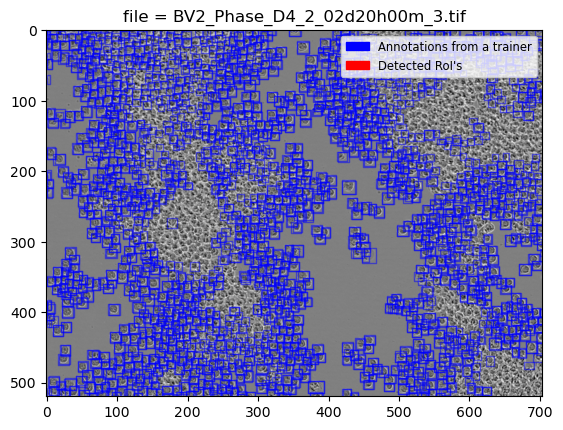

In [8]:
train_set.show_data(train_set.im.index[train_set.im.id==max_id][0], show_annotation=True)

### 2.3 Examples for available cell types
To review the available images, lets show 1 example for each cell type. For greater clarity, we will show images with the largest number of cell annotations.

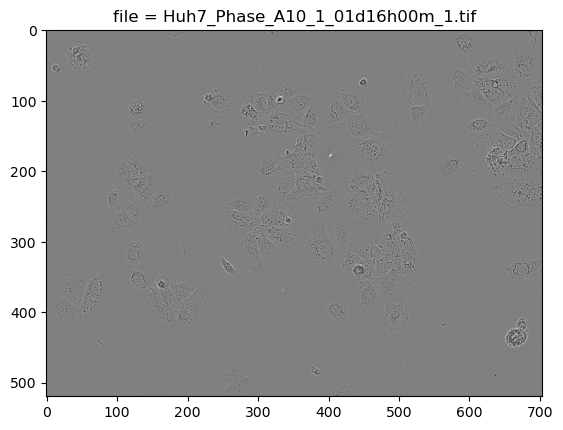

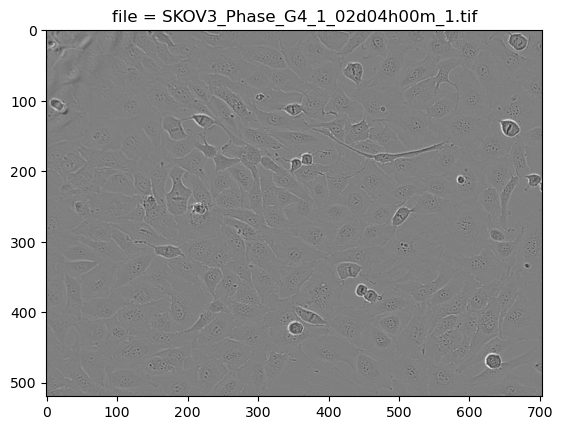

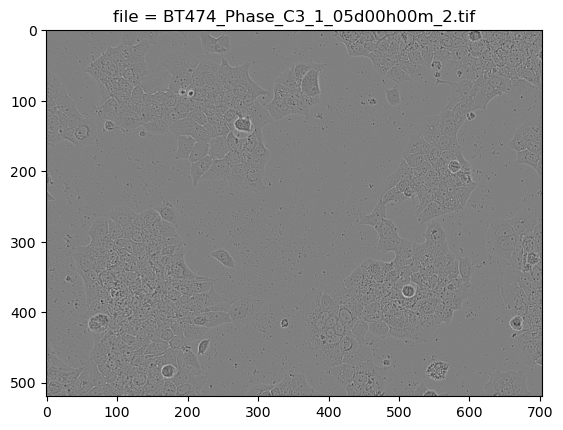

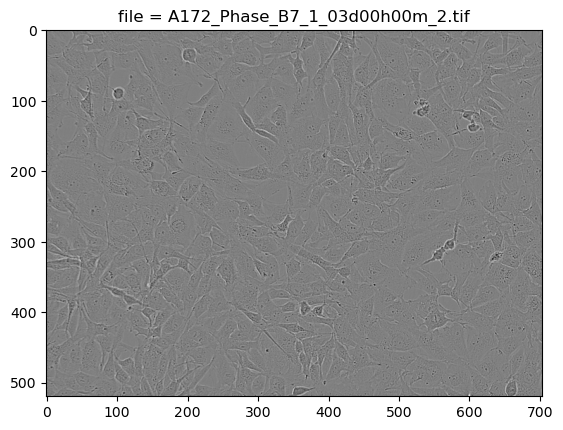

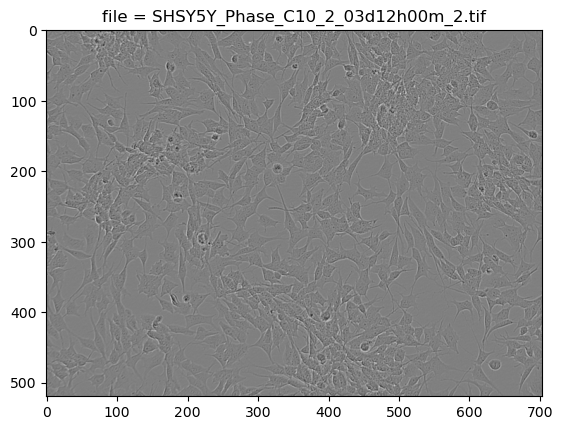

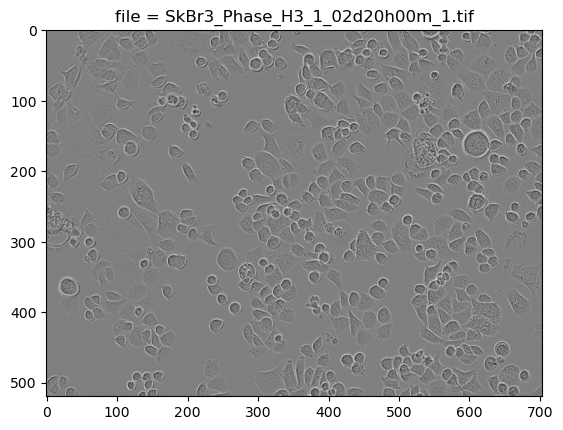

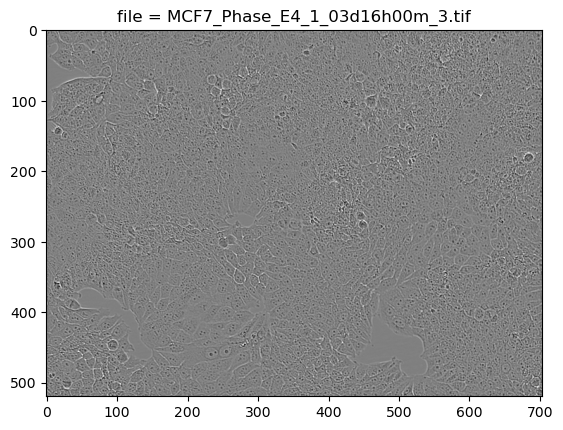

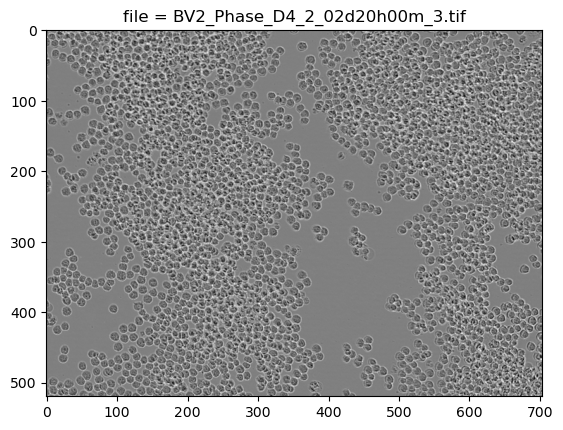

In [9]:
# Group statistic min, max, mean for cell type
ann_count_stat = ann_count.groupby(["cell_type"]).agg(
        min_cells_count=pd.NamedAgg(column='label', aggfunc='min'),
        max_cells_count=pd.NamedAgg(column='label', aggfunc='max'),
        average_cells_count=pd.NamedAgg(column='label', aggfunc=np.mean),
    )
ann_count_stat = ann_count_stat.sort_values("average_cells_count").reset_index()
for cell_type in ann_count_stat["cell_type"]:
    max_id = ann_count["label"][ann_count["cell_type"]==cell_type].idxmax()
    max_id = ann_count.iloc[max_id]["id"]
    train_set.show_data(train_set.im.index[train_set.im.id==max_id][0], show_annotation=False)

## 3. Use pre-trained Faster R-CNN model for cells detection
Let's start with a simple solution, use a pre-configured model.Here we load pre-trained model with default parameters and use it to detect cells.

In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
tr2 = weights.transforms()

Faster_RCNN_pretrained_model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
Faster_RCNN_pretrained_model = Faster_RCNN_pretrained_model.eval()

Let's test the loaded model on the picture with my cat.

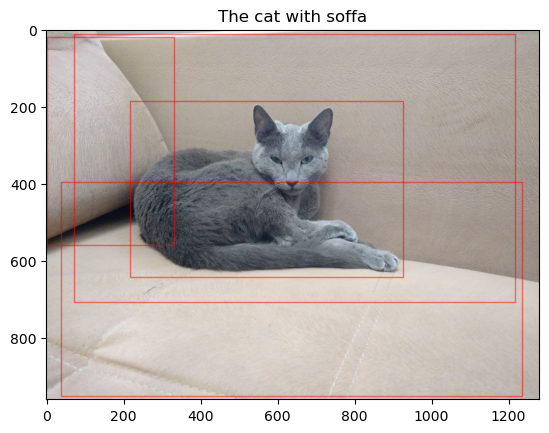

In [11]:
# Load, resize and transform image
test_img = Image.open("cat.tif").convert('RGB')
test_img_tensor = tr2(test_img)

# Call model for object detection
obj1 = Faster_RCNN_pretrained_model([test_img_tensor])
# Prepare rectangles with three highest scores
boxes1 =  [Rectangle((int(row[0]), int(row[1])),\
                     int(row[2]-row[0]), int(row[3]-row[1])) \
              for row in obj1[0]["boxes"][0:4]]

fig, ax = plt.subplots()
# Show image
ax.imshow(test_img)
ax.set_title('The cat with soffa')
# Create patch collection
pc = PatchCollection(boxes1, facecolor="none", edgecolor="red", alpha=0.5)
# Add collection to axes
ax.add_collection(pc)

We see that pre-trained model detect the cat and the soffa.
Let's try to detect cells on the microscope images.


In [12]:
# Create test dataset with transforms for pre-trained model
test_dataset = livecell(dataset_type=2, transform = tr2)

In [13]:
# Call model to detect anything on the first 5 images
try1_RoI = Faster_RCNN_pretrained_model([test_dataset[i][0] for i in range(0,5)])

print("There are no many RoI's detected on the first 5 images:", [try1_RoI[i]["boxes"].shape[0] for i in range(0, 5)])

There are no many RoI's detected on the first 5 images: [1, 3, 4, 1, 7]


Let's save and see RoI's for the image with index 4 (with maximum detected RoIs).

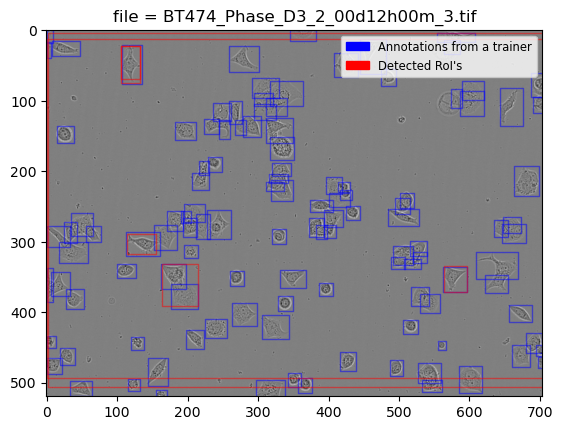

In [14]:
test_dataset.save_RoI(im_id=test_dataset.im.id[4], model="Pre Faster", boxes=try1_RoI[4])
test_dataset.show_data(4, show_annotation=True, RoI_model="Pre Faster", RoI_try_num=0)

We see that out of a large number of cells (blue), the model was able to detect only 3 (red). This suggests that the pre-trained model is good at recognizing the common objects it was trained on. But the pre-configured model is not suitable for finding cells in a microscope image.

## 4. Lets tune pretrained Faster R-CNN model for cells detection
For cells detection it will be enauph to train model for step "Regions of Interest" (RoI) selection.

In [16]:
NUM_EPOCHS = 10 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
MODEL_NAME = 'FasterT_v1' # Name to save the trained model with
BATCH_SIZE = 5 # increase / decrease according to GPU memeory
NUM_WORKERS = 0
SAMPLE_SIZE = 100
SKIP_MODEL_EDU = True

# Function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # Initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images   = data[0]
        targets  = data[1]
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # Update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.2f}")
    return train_loss_list

# Function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # Initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images   = data[0]
        targets  = data[1]
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # Update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.2f}")
    return val_loss_list

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if SKIP_MODEL_EDU:
    print("We skip long term educational cicle, and can use model with the best saved model parameters.")
    raise StopExecution

# load Faster RCNN pre-trained model
Faster_RCNN_tuned_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT",
                                                                              box_detections_per_img=500)

# Get the number of input features 
in_features = Faster_RCNN_tuned_model.roi_heads.box_predictor.cls_score.in_features
    
# Define a new head for the detector with 2 classes (cell or fone)
Faster_RCNN_tuned_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 
Faster_RCNN_tuned_model = Faster_RCNN_tuned_model.to(DEVICE)

# Get the model parameters that need to be optimized
params = [p for p in Faster_RCNN_tuned_model.parameters() if p.requires_grad]
# Define the optimizer for model parameters
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# Initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# Train and validation loss lists to store loss values of all iterations
train_loss_list = []
val_loss_list = []
# Define train and validation dataset
train_dataset = livecell(dataset_type=1, sample_count=SAMPLE_SIZE)
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )
valid_dataset = livecell(dataset_type=3, sample_count=SAMPLE_SIZE)
valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

# Initialize SaveBestModel class
save_best_model = SaveBestModel()
# Start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"EPOCH {epoch+1} of {NUM_EPOCHS}")
    # Reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # Start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, Faster_RCNN_tuned_model)
    val_loss = validate(valid_loader, Faster_RCNN_tuned_model)
    end = time.time()
    print(f"Epoch #{epoch+1}, train loss: {train_loss_hist.value:.3f}, validation loss: {val_loss_hist.value:.3f}, took {((end - start) / 60):.3f} minutes.")
    # Save the best model till now if we have the least loss in the current epoch
    save_best_model(
        val_loss_hist.value, epoch, Faster_RCNN_tuned_model, optimizer
    )
    # Save the current epoch model
    save_model(epoch, Faster_RCNN_tuned_model, optimizer)
        
    # Sleep for 5 seconds after each epoch
    time.sleep(5)


We skip long term educational cicle, and can use model with the best saved model parameters.


Now let's visually check how well our trained model works.
To do this, we will load its best saved parameters and start searching for cells in the same microscope images.


In [17]:
# Create Faster RCNN default model
best_Faster_RCNN_tuned_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT",
                                                                                    box_detections_per_img=500)
# Get the number of input features 
in_features = best_Faster_RCNN_tuned_model.roi_heads.box_predictor.cls_score.in_features
    
# Define a new head for the detector with 2 classes (cell or fone)
best_Faster_RCNN_tuned_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 
# Load and setup parameters from saved best model
checkpoint = torch.load('C:\\temp\\datasets\\mediag\\models\\best_model.pth', map_location=DEVICE)
best_Faster_RCNN_tuned_model.load_state_dict(checkpoint['model_state_dict'])

best_Faster_RCNN_tuned_model = best_Faster_RCNN_tuned_model.to(DEVICE).eval()

In [18]:
# Call model to detect anything on the first 5 images
try1_RoI = best_Faster_RCNN_tuned_model([test_dataset[i][0] for i in range(0,5)])

print("There are many RoI's detected on the first 5 images:", [try1_RoI[i]["boxes"].shape[0] for i in range(0, 5)])

There are many RoI's detected on the first 5 images: [268, 233, 173, 289, 130]


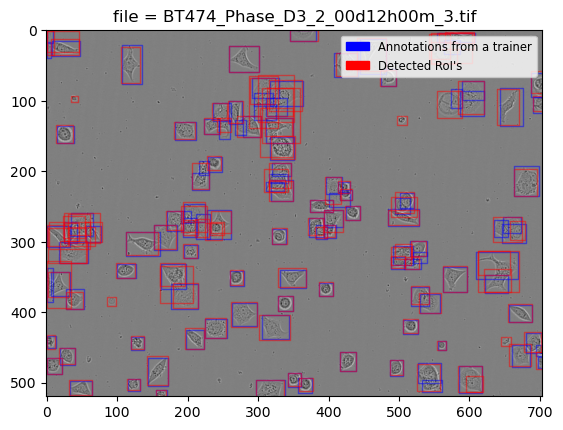

In [19]:
test_dataset.save_RoI(im_id=test_dataset.im.id[4], model=MODEL_NAME, boxes=try1_RoI[4])
test_dataset.show_data(4, show_annotation=True, RoI_model=MODEL_NAME, RoI_try_num=0)

We see that tuned model gave us good results. Let's test our model for real microscope image from diagnostic laboratory.

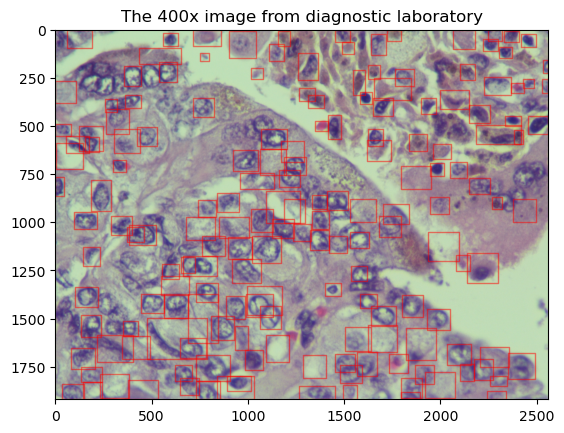

In [20]:
# Load, resize and transform image
test_img = Image.open("C:\\temp\\datasets\\mediag\\images\\expert_images\\EI1ptc_CIx400_0009.jpg").convert('RGB')
test_img_tensor = tr2(test_img)

# Call model for object detection
obj1 = best_Faster_RCNN_tuned_model([test_img_tensor])
# Prepare rectangles with top 169 scores
boxes1 =  [Rectangle((int(row[0]), int(row[1])),\
                     int(row[2]-row[0]), int(row[3]-row[1])) \
              for row in obj1[0]["boxes"][0:170]]

fig, ax = plt.subplots()
# Show image
ax.imshow(test_img)
ax.set_title('The 400x image from diagnostic laboratory')

# Create patch collection
pc = PatchCollection(boxes1, facecolor="none", edgecolor="red", alpha=0.5)
# Add collection to axes
ax.add_collection(pc)

Here we import some examples into our testing dataset. 

In [21]:
test_dataset.add_images("C:\\temp\\datasets\\mediag\\images\\expert_images\\")
test_dataset.im[test_dataset.im["cell_type"]=="EI1ptc"]

id               file_name  width  height cell_type
0   1694939  EI1ptc_CIx200_0010.jpg   2560    1920    EI1ptc
1   1694940  EI1ptc_CIx400_0008.jpg   2560    1920    EI1ptc
2   1694941  EI1ptc_CIx400_0009.jpg   2560    1920    EI1ptc
3   1694942  EI1ptc_GIx200_0002.jpg   2560    1920    EI1ptc
4   1694943  EI1ptc_GIx200_0003.jpg   2560    1920    EI1ptc
5   1694944  EI1ptc_GIx200_0008.jpg   1280     960    EI1ptc
6   1694945  EI1ptc_GIx400_0001.jpg   2560    1920    EI1ptc
7   1694946  EI1ptc_GIx400_0004.jpg   2560    1920    EI1ptc
8   1694947  EI1ptc_GIx400_0005.jpg   2560    1920    EI1ptc
9   1694948  EI1ptc_GIx400_0006.jpg   2560    1920    EI1ptc
10  1694949  EI1ptc_GIx400_0007.jpg   2560    1920    EI1ptc

We see that added sample consist of high resolution images (2560 * 1920). These photographs contain images that the microscope has magnified 200 or 400 times. Cell type coded for PTC - papillary thyroid carcinoma, https://en.wikipedia.org/wiki/Papillary_thyroid_cancer.

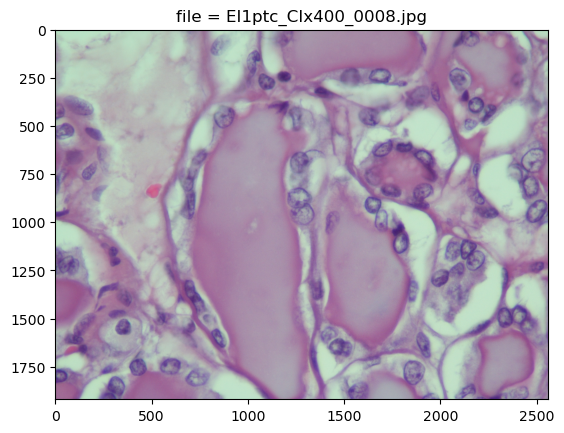

In [22]:
# Call the best model to detect cells on an image from this sample
ei_indexes = test_dataset.im[test_dataset.im["cell_type"]=="EI1ptc"].index
test_dataset.show_data(1)
#try_ei1_RoI = best_Faster_RCNN_tuned_model(test_dataset[ei_id[1:2].index])
#test_dataset.save_RoI(ei_id[1:2].index, model=MODEL_NAME)
#test_dataset.show_data(ei_id[1:2].index, show_annotation=True, RoI_model=MODEL_NAME, RoI_try_num=0)

Based on the current results, the following will be worked out in a future version (backlog for next version):
- training on the full range of LIVEcell
- development of recognition quality criteria
- training on one type of cell (the most suitable for laboratory samples with healthy and diseased cells)

...

**Author: Vitaly Kogtev**

**Email: [Vitaly.Kogtev@gmail.com](mail:Vitaly.Kogtev@gmail.com)**

**Telegram: https://t.me/VitalyKogtev**